In [1]:
# Load self-defined functions.
%run tools.ipynb

# Import libraries.
import os
import time
import shutil
import pickle

from KRFD import KRSFD_model # KRSFD model.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import optuna # For Bayesian optimization of the hyper-parameters of KRSFD.
from sklearn.model_selection import KFold
import joblib

optuna.logging.set_verbosity(optuna.logging.WARNING) ## Silence the outputs of optuna.

# Create a directory for saving results.
new_dir = "Artificial_data_sparse"
if os.path.exists(new_dir):
    shutil.rmtree(new_dir)
os.mkdir(new_dir)

In [2]:
# Set random seed.
np.random.seed(seed=1122)

# Create an artificial data set (sparse functional data).
num_N = 500 # Number of samples.
num_T = 30 # Number of kernels on t-space.
sigma = 0.2 # Sigma of observation noise.

# Set the parameters of the function y = f(t).
a = np.random.uniform(1, 5, num_N)  # amplitude
b = np.random.uniform(1, 5, num_N)  # frequency
c = np.random.uniform(0, 3, num_N)  # phase
d = np.random.uniform(-2, 2, num_N) # slope
e = np.random.uniform(-3, 3, num_N) # intercept

# X
X = np.array([a,b,c,d,e]).T
print(f"X: {X.shape}")

# ts
ts = []
for i in range(num_N):
    # Number of samples for the ith system.
    num_N_i = np.random.choice(np.arange(2,21), 1)
    # Values of ts for the ith system.
    ts.append(np.sort(np.random.uniform(0, 2, num_N_i)))

# Ys
Ys = []
for i in range(num_N):
    Ys.append(X[i,0] * np.sin(X[i,1]*ts[i] + X[i,2]) + X[i,3]*ts[i] + X[i,4] + np.random.normal(0, sigma, len(ts[i])))

# Set fixed grids on t-space.
t_grid = np.linspace(0, 2, num_T)
print(f"t_grid: {len(t_grid)}")

# Divide data into training and test set.
divided_samples = train_test_split(num_N, test_prop=0.25)
    
X_train = X[divided_samples["train_ids"]]
Ys_train = [Ys[divided_samples["train_ids"][i]] for i in range(len(divided_samples["train_ids"]))]
ts_train = [ts[divided_samples["train_ids"][i]] for i in range(len(divided_samples["train_ids"]))]
X_test = X[divided_samples["test_ids"]]
Ys_test = [Ys[divided_samples["test_ids"][i]] for i in range(len(divided_samples["test_ids"]))]
ts_test = [ts[divided_samples["test_ids"][i]] for i in range(len(divided_samples["test_ids"]))]
print(f"number of training systems: {X_train.shape[0]}, number of test systems: {X_test.shape[0]}")
print(f"number of training samples: {len(np.concatenate(ts_train))}, number of test samples: {len(np.concatenate(ts_test))}")

# Y_true for depicting true systems.
true_t = np.linspace(0, 2, 51) 
true_Y = np.array([X[i,0] * np.sin(X[i,1]*true_t + X[i,2]) + X[i,3]*true_t + X[i,4] for i in range(num_N)])
true_Y_test = true_Y[divided_samples["test_ids"]]

# Get K-folds cross-validation dataset for hyper-parameter optimization.
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
k_folds = []
for cv_train_index, cv_test_index in kf.split(X_train):
    # train-test split for cv.
    cv_X_train, cv_X_test = X_train[cv_train_index], X_train[cv_test_index]
    cv_Ys_train, cv_Ys_test = [Ys_train[cv_train_index[i]] for i in range(len(cv_train_index))], [Ys_train[cv_test_index[i]] for i in range(len(cv_test_index))]
    cv_ts_train, cv_ts_test = [ts_train[cv_train_index[i]] for i in range(len(cv_train_index))], [ts_train[cv_test_index[i]] for i in range(len(cv_test_index))]
    
    k_folds.append({"X_train":cv_X_train, "X_test":cv_X_test, "Ys_train":cv_Ys_train, "Ys_test":cv_Ys_test,
                   "ts_train":cv_ts_train, "ts_test":cv_ts_test})

X: (500, 5)
t_grid: 30
number of training systems: 375, number of test systems: 125
number of training samples: 3964, number of test samples: 1449


In [3]:
# Define functions.

# Define a function for parallel cross-validation for model.
def model_cv(i, model, k_folds = k_folds):
    # Training model.
    model.fit(k_folds[i]["X_train"], k_folds[i]["ts_train"], k_folds[i]["Ys_train"], t_grid, verbose = False)
    # Validation on test-set.
    pred = model.predict(k_folds[i]["X_test"], k_folds[i]["ts_test"])
    MAE = np.mean(np.abs(pred - np.concatenate(k_folds[i]["Ys_test"])))
    return MAE

# Test metrics.
def test_metrics(Y_pred_test, Y_test):
    pred = Y_pred_test.flatten()
    obs = Y_test.flatten()
    
    MAE = np.mean(np.abs(pred - obs))
    RMSE = (np.mean((pred - obs)**2))**(1/2)
    R2 = (np.corrcoef(pred, obs)[0, 1])**2
    return MAE, RMSE, R2

# Function for plotting pred vs obs graph.
def pred_obs_plot(Y_pred_test, Y_test, address, dpi = 400):
    # Plot Prediction vs Onservation plot on the test set.
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    # Calculate metrics.
    pred, obs = Y_pred_test.flatten(), Y_test.flatten()
    MAE, RMSE, R2 = test_metrics(Y_pred_test, Y_test)
    # Scatter plot.
    ax.scatter(pred, obs)
    labels = []
    labels.append(f"MAE = {MAE:.3f}")
    labels.append(f"RMSE = {RMSE:.3f}")
    labels.append(r"$R^2=$"+f"{R2:.3f}")
    
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white",lw=0, alpha=0)] * 4
    ax.legend(handles, labels, loc='best', fontsize='x-large',fancybox=True, framealpha=0.7,handlelength=0, handletextpad=0)
    plt.title(f"Pred vs Obs on test set (N={Y_test.shape[0]})", fontsize="xx-large")
    
    plt.xlabel(r"Prediction", fontsize="xx-large")
    plt.ylabel(r"Observation", fontsize="xx-large")
    margin = 1.05
    plt.xlim(min(np.min(pred),np.min(obs))*margin, max(np.max(pred),np.max(obs))*margin)
    plt.ylim(min(np.min(pred),np.min(obs))*margin, max(np.max(pred),np.max(obs))*margin)
    diag = np.linspace(min(np.min(pred),np.min(obs))*margin, max(np.max(pred),np.max(obs))*margin)
    plt.plot(diag, diag, '--', color = "grey") 
    fig.tight_layout()
    plt.savefig(address, dpi = 400)
    
# Save indivisual functional prediction.
def Save_plot(X_test, Ys_test, ts_test, Y_pred_test, Y_true_test, t_true, new_dir, dpi = 400):
    # Create new directory.
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.mkdir(new_dir)
    # Save individual plot.
    for i in range(Y_pred_test.shape[0]):
        fig = plt.figure(figsize=(6,4))
        plt.scatter(ts_test[i], Ys_test[i], label="Obs",color = "red", s = 2)
        plt.plot(t_true, Y_true_test[i,:], label="True",color = "gray")
        plt.plot(t_true, Y_pred_test[i,:], label="Pred",color = "cyan")
        plt.legend()
        plt.title(f"X = [amp: {X_test[i,0]:.2f},frq: {X_test[i,1]:.2f},phs: {X_test[i,2]:.2f},slp: {X_test[i,3]:.2f},int: {X_test[i,4]:.2f}]", fontsize="large")
        plt.xlim(-0.05, 2.05)
        plt.xlabel("t", fontsize="large")
        plt.ylabel("Y(X, t)", fontsize="large")
        fig.tight_layout()
        plt.savefig(f"{new_dir}/{i+1}-amp{X_test[i,0]:.2f}-frq{X_test[i,1]:.2f}-phs{X_test[i,2]:.2f}-slp{X_test[i,3]:.2f}-int{X_test[i,4]:.2f}.png", dpi = dpi)
        plt.close()

Best hyper-parameters: {'sigma_G': 1.3773098170466815, 'sigma_T': 0.13425399095421187, 'lambda_H': 0.056520743745891514, 'zero_ratio_G': 0.4034497081712135, 'kernel_X': 'Gaussian', 'kernel_T': 'Gaussian'}
Best validation MAE: 0.6416379895296226
Calculation time: 683.2984750270844


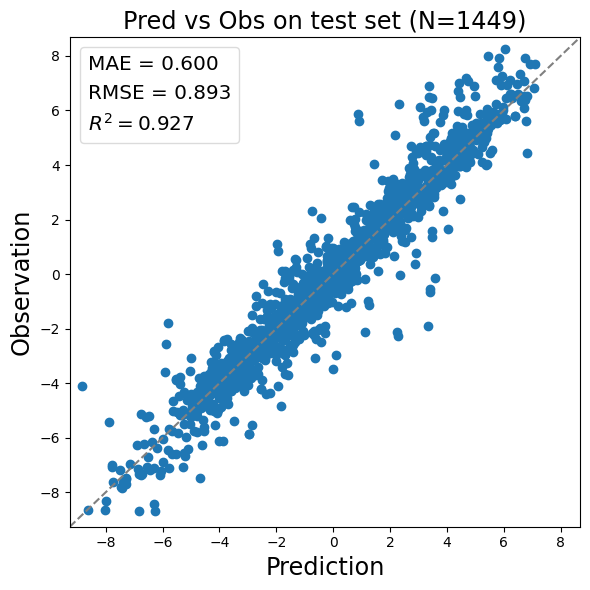

In [4]:
### KRSFD on the sparse functional data.

zero_ratio_H = 0.9
# Define an optuna-objective function.
def objective(trial):

    # Set region of the hyperparameters of the KRSFD model.
    sigma_G = trial.suggest_float('sigma_G', 0.1, 100, log = True)
    sigma_T = trial.suggest_float('sigma_T', 0.1, 100, log = True)

    lambda_H = trial.suggest_float('lambda_H', 1e-06, 1, log = True)
    zero_ratio_G = trial.suggest_float('zero_ratio_G', 0.1, zero_ratio_H)
    zero_ratio_T = (zero_ratio_H - zero_ratio_G)/(1 - zero_ratio_G)
    
    kernel_X = trial.suggest_categorical('kernel_X', ['Gaussian', 'Laplacian'])
    kernel_T = trial.suggest_categorical('kernel_T', ['Gaussian', 'Laplacian'])
    
    # Set hyper-parameters.
    krsfd = KRSFD_model([zero_ratio_G, zero_ratio_T], [sigma_G, sigma_T], lambda_H,
                       kernel_types = [kernel_X, kernel_T])
    
    # Cross-validation with multicores.
    score = joblib.Parallel(n_jobs=-1)(joblib.delayed(model_cv)(i, model = krsfd) for i in range(len(k_folds)))
    
    return np.mean(score)

# Run optuna for hyper-parameter optimization.
start = time.time()
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42)) # Set seed.
study.optimize(objective, n_trials=300)
print(f"Best hyper-parameters: {study.best_params}")
print(f"Best validation MAE: {study.best_value}")
# Save study.
study.trials_dataframe().to_csv(f"{new_dir}/KRSFD_study.csv")
end = time.time()
print(f"Calculation time: {end - start}")

# Train KRSFD model with the selected hyper-parameters.
best_sigmas = [study.best_trial.params['sigma_G'], study.best_trial.params['sigma_T']]
zero_ratio_G = study.best_params["zero_ratio_G"]
zero_ratio_T = (zero_ratio_H - zero_ratio_G)/(1 - zero_ratio_G)
best_zero_ratios = [zero_ratio_G, zero_ratio_T]
best_lambda = study.best_params["lambda_H"]
best_kernels = [study.best_trial.params['kernel_X'], study.best_trial.params['kernel_T']]

krsfd = KRSFD_model(best_zero_ratios, best_sigmas, best_lambda, kernel_types = best_kernels) # Set the selected hyper-parameters.
krsfd.fit(X_train, ts_train, Ys_train, t_grid, verbose=False) # Training model.

# Make predictions on test set.
Y_pred_test = krsfd.predict(X_test, ts_test)

# Plot results.
pred_obs_plot(Y_pred_test, np.concatenate(Ys_test), f"{new_dir}/ArtificialSparse_KRSFD.png") # parity plot.
Y_pred_test = krsfd.predict(X_test, true_t) # prediction results on dense observation points (true_t).
Save_plot(X_test, Ys_test, ts_test, Y_pred_test, 
          true_Y_test, true_t, f"{new_dir}/KRSFD", 200) # indivisual results.

In [5]:
### Bayesian prediction with the trained KRSFD model.

start = time.time()
krsfd.fit(X_train, ts_train, Ys_train, t_grid, cov_Theta = True, verbose=False) # Training model with cov_Theta = True.
end = time.time()
print(f"Calculation time: {end - start}")

# 1. Output predicition means and stds for the test set.
Y_pred_mean_test, Y_pred_std_test = krsfd.predict(X_test, true_t, std = True)

# Save individual prediction results for the test set.
start = time.time()

new_dir_std = f"{new_dir}/KRSFD (mean ± std)"
if os.path.exists(new_dir_std):
    shutil.rmtree(new_dir_std)
os.mkdir(new_dir_std)

for i in range(Y_pred_mean_test.shape[0]):
    fig = plt.figure(figsize=(6,4))
    plt.scatter(ts_test[i], Ys_test[i], label="Obs",color = "red", s = 2)
    plt.plot(true_t, true_Y_test[i,:], label="True",color = "gray")
    plt.plot(true_t, Y_pred_mean_test[i,:], label="Pred_mean",color = "cyan")
    # add one sigma band.
    plt.fill_between(true_t, Y_pred_mean_test[i,:]-Y_pred_std_test[i,:], Y_pred_mean_test[i,:]+Y_pred_std_test[i,:],
                 alpha=.5, label='mean ± std')
    
    plt.legend()
    plt.title(f"X = [amp: {X_test[i,0]:.2f},frq: {X_test[i,1]:.2f},phs: {X_test[i,2]:.2f},slp: {X_test[i,3]:.2f},int: {X_test[i,4]:.2f}]", fontsize="large")
    plt.xlim(-0.05, 2.05)
    plt.xlabel("t", fontsize="large")
    plt.ylabel("Y(X, t)", fontsize="large")
    fig.tight_layout()
    plt.savefig(f"{new_dir_std}/{i+1}-amp{X_test[i,0]:.2f}-frq{X_test[i,1]:.2f}-phs{X_test[i,2]:.2f}-slp{X_test[i,3]:.2f}-int{X_test[i,4]:.2f}.png", dpi = 200)
    plt.close()
    
end = time.time()
print(f"Calculation time: {end - start}")

# 2. Sampling of predicted funcutions for the test set.
size = 300

np.random.seed(seed=1122) # Set random seed.
test_sampling = krsfd.predict_sampling(X_test, true_t, size)

# Save individual prediction results for the test set.
start = time.time()

new_dir_samp = f"{new_dir}/KRSFD (sampling)"
if os.path.exists(new_dir_samp):
    shutil.rmtree(new_dir_samp)
os.mkdir(new_dir_samp)

for i in range(len(test_sampling)):
    
    fig = plt.figure(figsize=(6,4))

    plt.plot(true_t, test_sampling[i][0,:], color = "cyan", alpha = 0.1, label = f"Samps (N={size})")
    for j in range(1, test_sampling[i].shape[0]):
        plt.plot(true_t, test_sampling[i][j,:], color = "cyan", alpha = 0.1)
    plt.scatter(ts_test[i], Ys_test[i], label="Obs",color = "red", s = 2)
    plt.plot(true_t, true_Y_test[i,:], label="True",color = "gray")
    legend = plt.legend()
    for legend_handle in legend.legend_handles:
        legend_handle.set_alpha(1) # Set legend alpha to 1.
    plt.title(f"X = [amp: {X_test[i,0]:.2f},frq: {X_test[i,1]:.2f},phs: {X_test[i,2]:.2f},slp: {X_test[i,3]:.2f},int: {X_test[i,4]:.2f}]", fontsize="large")
    plt.xlim(-0.05, 2.05)
    plt.xlabel("t", fontsize="large")
    plt.ylabel("Y(X, t)", fontsize="large")
    fig.tight_layout()
    plt.savefig(f"{new_dir_samp}/{i+1}-amp{X_test[i,0]:.2f}-frq{X_test[i,1]:.2f}-phs{X_test[i,2]:.2f}-slp{X_test[i,3]:.2f}-int{X_test[i,4]:.2f}.png", dpi = 200)
    plt.close()

end = time.time()
print(f"Calculation time: {end - start}")

Calculation time: 168.43713402748108
Calculation time: 15.904462099075317


/Users/minorukusaba/Desktop/KRFD/KRFD.py:755: RuntimeWarning: covariance is not positive-semidefinite.
  pred_sampling = np.random.multivariate_normal(pred_mean, pred_cov, size) # random sampling.


Calculation time: 43.88413190841675
